In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
from astropy import constants as const
# import exoplanet as xo

In [4]:
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)
ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])
names = np.array(m_dwarf_sample[m_dwarf_sample.columns[2]])
masses = np.array(m_dwarf_sample[["Mass"]])

In [239]:
names[10]

'G 172-1'

In [105]:
def process(lc,smooth_size): 
    # flatten and remove flares
    clean_lc = lc.remove_nans().remove_outliers(3)
    clean_lc.plot()
    ppm_unit = clean_lc.flux[0].unit
    flat_lc, trend_lc = clean_lc.flatten(window_length=smooth_size, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)
    flat_lc = flat_lc.remove_outliers(3)
    # residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
    # flat_lc['flux'] = residuals
    flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6
    # flat_lc = flat_lc.remove_outliers(3)
    # get perio
    # frequency = np.arange(1, 4000,0.008)
    flat_lc.plot()

    perio = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
    threshold =  4*np.mean(np.array(perio.power))
    threshold_freq = [(i*10**6)/(24*60*60) for i in np.array(perio.smooth(filter_width=20).frequency)]
    # perio = perio.smooth(filter_width=2)
    perio_psd = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,1),normalization='psd').smooth(filter_width=2)

    # get thresholds

    # flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).plot()
    # plt.axhline(y=threshold,color='red')
    # plt.show()
    perio_psd.plot(scale='log')
    plt.show()
    
    frequency_hz = [(i*10**6)/(24*60*60) for i in np.arange(2, 2160,0.008)]
    # indices
    plt.figure(figsize=(10,5))
    plt.plot(frequency_hz,np.array(flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).power),color='black',alpha=.8)
    plt.xlabel("Frequency [uHz]",fontsize=15)
    plt.ylabel("Amp. [ppm]",fontsize=15)
    plt.axhline(y=threshold,color='red')
    plt.tick_params(labelsize=10)
    # plt.xscale('log')
    plt.show()
    print('max',frequency_hz[np.argmax(np.array(perio.power))])
    return perio, perio_psd, threshold

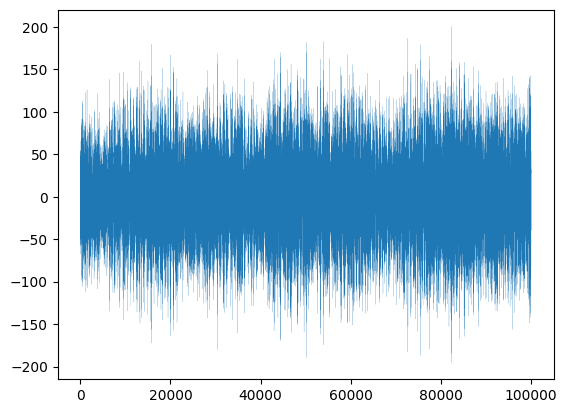

In [437]:
ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/s4tess_llrgb.asc")
len(ascii_grid)
plt.plot(ascii_grid,linewidth=.1)

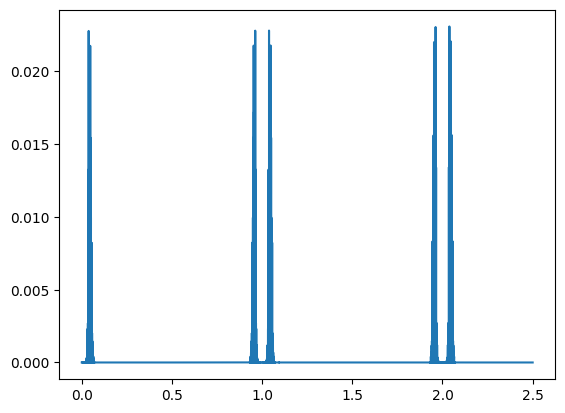

In [436]:
t=np.arange(0,len(ascii_grid),1)
frequency, power = LombScargle(t, ascii_grid).autopower()
plt.plot(frequency,power)

In [408]:
no_gran_ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/no_gran_s4tess_llrgb.asc")
len(no_gran_ascii_grid)

19728

In [409]:
ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/s4tess_llrgb.asc")
len(ascii_grid)

100000

In [500]:
def get_fake_lc(lc,amp,smooth_size):
    lc = lc.normalize(unit='ppm')
    rand = np.random.default_rng(42)
    clean_lc = lc.remove_nans().remove_outliers(3)
    clean_lc = clean_lc[:len(ascii_grid)]

    # clean_lc.plot()
    ppm_unit = clean_lc.flux.unit
        # lc['flux'] = (noise+baseline)
    clean_lc['flux'] = clean_lc['flux'] + amp*ascii_grid*ppm_unit*(1/np.std(ascii_grid))

    flat_lc, trend_lc = clean_lc.flatten(window_length=smooth_size, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)

    flat_lc = flat_lc.remove_outliers(3)
    # residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
    # flat_lc['flux'] = residuals
    flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6

    clean_lc = flat_lc

    noise = np.std((clean_lc['flux'])) * np.random.normal(size=len(t))
    baseline = np.mean((clean_lc['flux']))

    return clean_lc, ppm_unit

In [422]:
# load the time stamps of a TESS observation
row = 10
lcf = lk.search_lightcurve('Gaia DR3  240259375324767744', mission='TESS',exptime=20).download()
lc = lcf.PDCSAP_FLUX.remove_nans()

/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_35923/2711936640.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans()


In [476]:
def get_gaussian_lc(lc):
    rand = np.random.default_rng(42)
    lc = lc.remove_nans()
    t = lc.time.value
    clean_lc = lc.remove_outliers(4)


    noise = np.std((clean_lc['flux'])) * np.random.normal(size=len(t))
    baseline = np.mean((clean_lc['flux']))


    lc['flux'] = (noise+baseline)

    return lc

In [506]:
def inject_oscillations(amp,show,num,smooth_size,fake):


    perios = []
    perio_psds = []
    flats = []

    for i in range(num):
        if fake:
            gaussian_lc = get_gaussian_lc(lc)
        else:
            gaussian_lc= lc
        fake_lc,ppm_unit = get_fake_lc(gaussian_lc,amp,smooth_size)
        perio = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
        perio_psd = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,.1),normalization='psd').smooth(filter_width=10)
        flat = perio_psd.flatten()
        flat_unit = flat.power.unit
        print(perio.power)

        perios.append(np.array(perio.power))
        perio_psds.append(np.array(perio_psd.power))
        flats.append(np.array(flat.power))


    perio.power = sum(perios)*ppm_unit
    perio_psd.power = sum(perio_psds)*ppm_unit
    flat.power = sum(flats)*flat_unit

    summed_flat = perio_psd.flatten()

    if show:
        fig, axs = plt.subplots(3,2,figsize=(20,15))
        lc.plot(ax=axs[0][0],color='black',alpha=.8)
        fake_lc.plot(ax=axs[0][1],color='black',alpha=.8)

        perio.plot(ax=axs[1][0],color='black',alpha=.8)
        max_index = [np.round(i,2) for i in list(np.arange(20, 20000,.1))].index(2200)
        # max_index = 2200

        perio_psd.plot(ax=axs[1][1],color='black',alpha=.8,scale='log')

        perio_psd[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=axs[2][0],color='black',alpha=.8)

        flat.plot(ax=axs[2][1],color='black',alpha=.8)

        axs[0][0].set_title('Original Lightcurve')
        axs[0][1].set_title('Normalized Light Curve')
        axs[1][0].set_title('Power Spectrum')
        axs[1][1].set_title('PSD')
        axs[2][0].set_title('Zoomed-In Oscillations')
        axs[2][1].set_title('Flattened PSD')


        plt.suptitle(f"Injected Oscillations Amplitude = {amp} ppm",fontsize=30)

        plt.subplots_adjust(hspace=.5)
        plt.show()

    fig, ax = plt.subplots(1, 1,figsize=(20,10))
    summed_flat.plot(ax=ax,color='black',alpha=.8)
    plt.show()


[0.12683033 0.12766165 0.12804702 ... 1.63309454 1.62827267 1.62490744] ppm


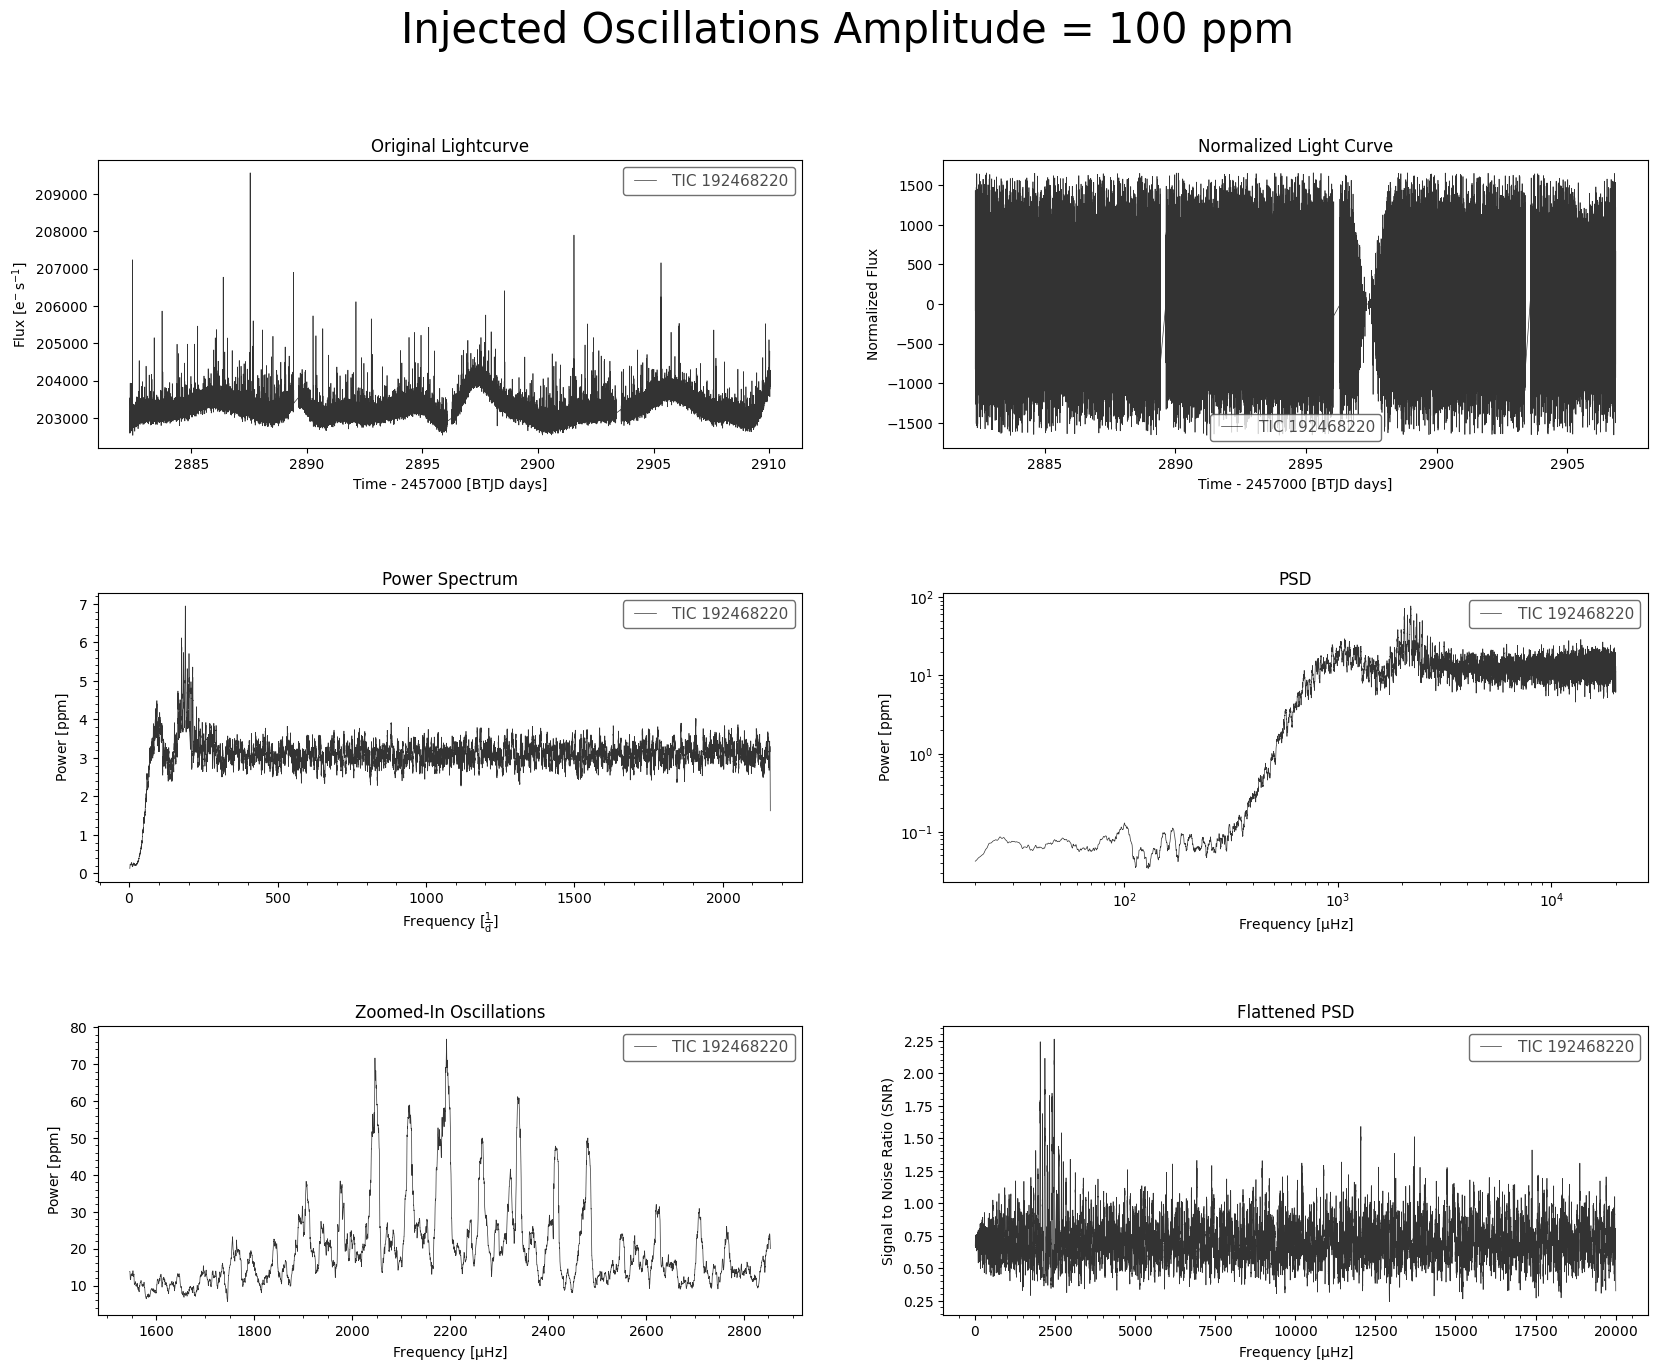

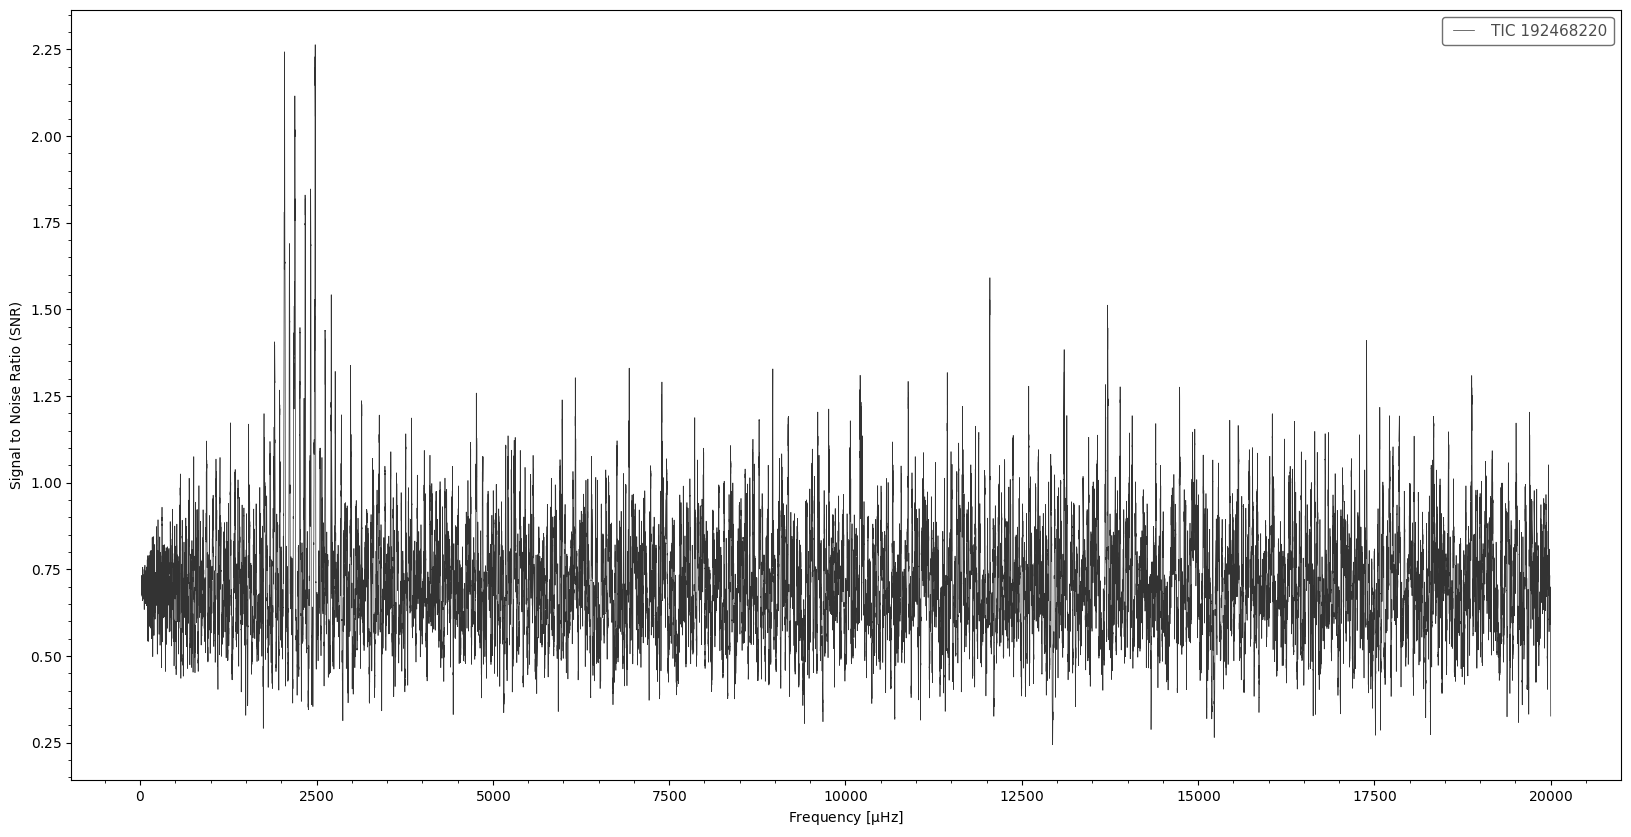

In [507]:
inject_oscillations(100,True,1,101,False)

[1.48267378 1.5187994  1.55397458 ... 4.1049288  4.07992498 4.0616456 ] ppm
[1.26367632 1.27144292 1.284707   ... 4.15539141 4.14703486 4.1369028 ] ppm
[1.73051919 1.73511465 1.74238971 ... 4.21310975 4.1700923  4.13102377] ppm
[1.2842717  1.33604267 1.38784286 ... 3.99528403 3.96373637 3.92612525] ppm
[1.59594634 1.61455328 1.62947568 ... 3.40285581 3.39108196 3.3741869 ] ppm


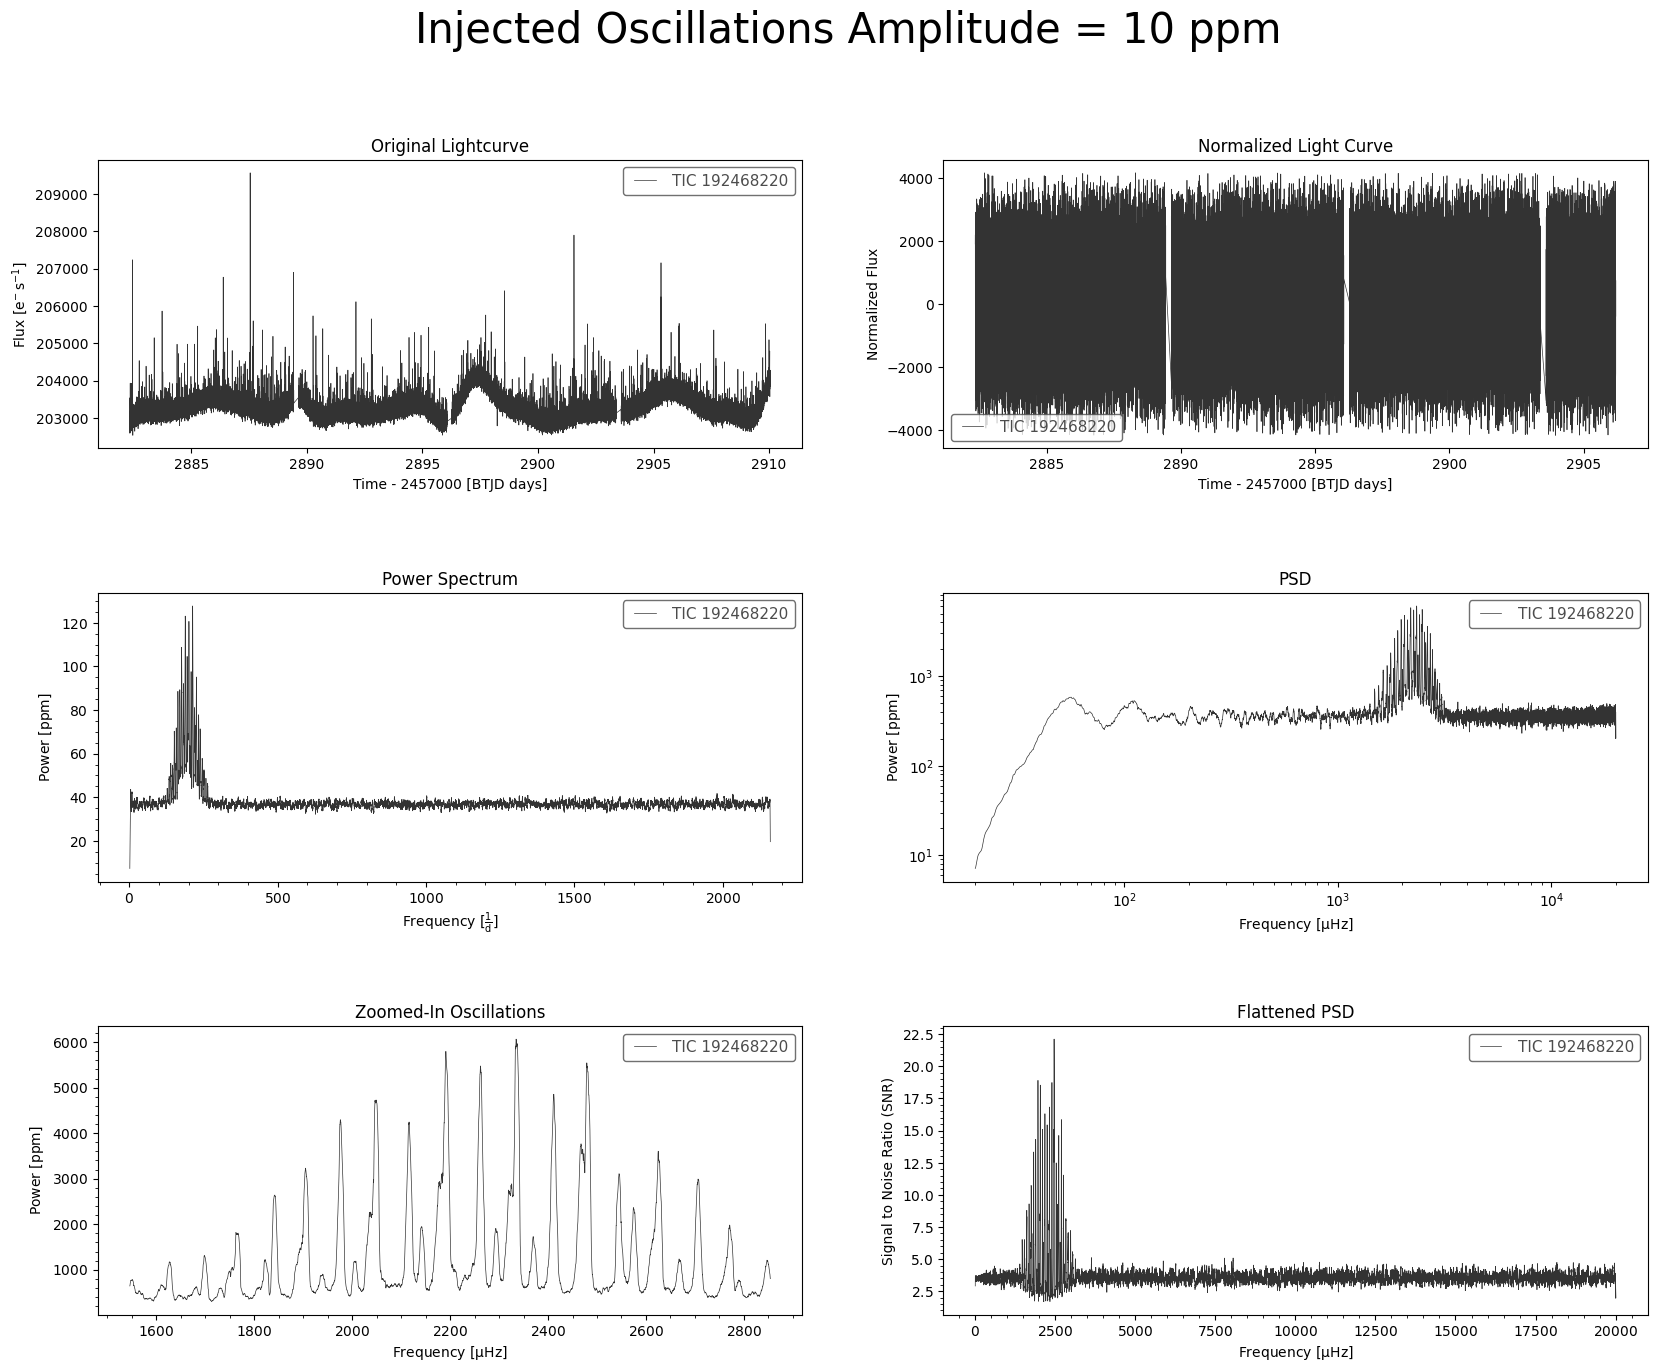

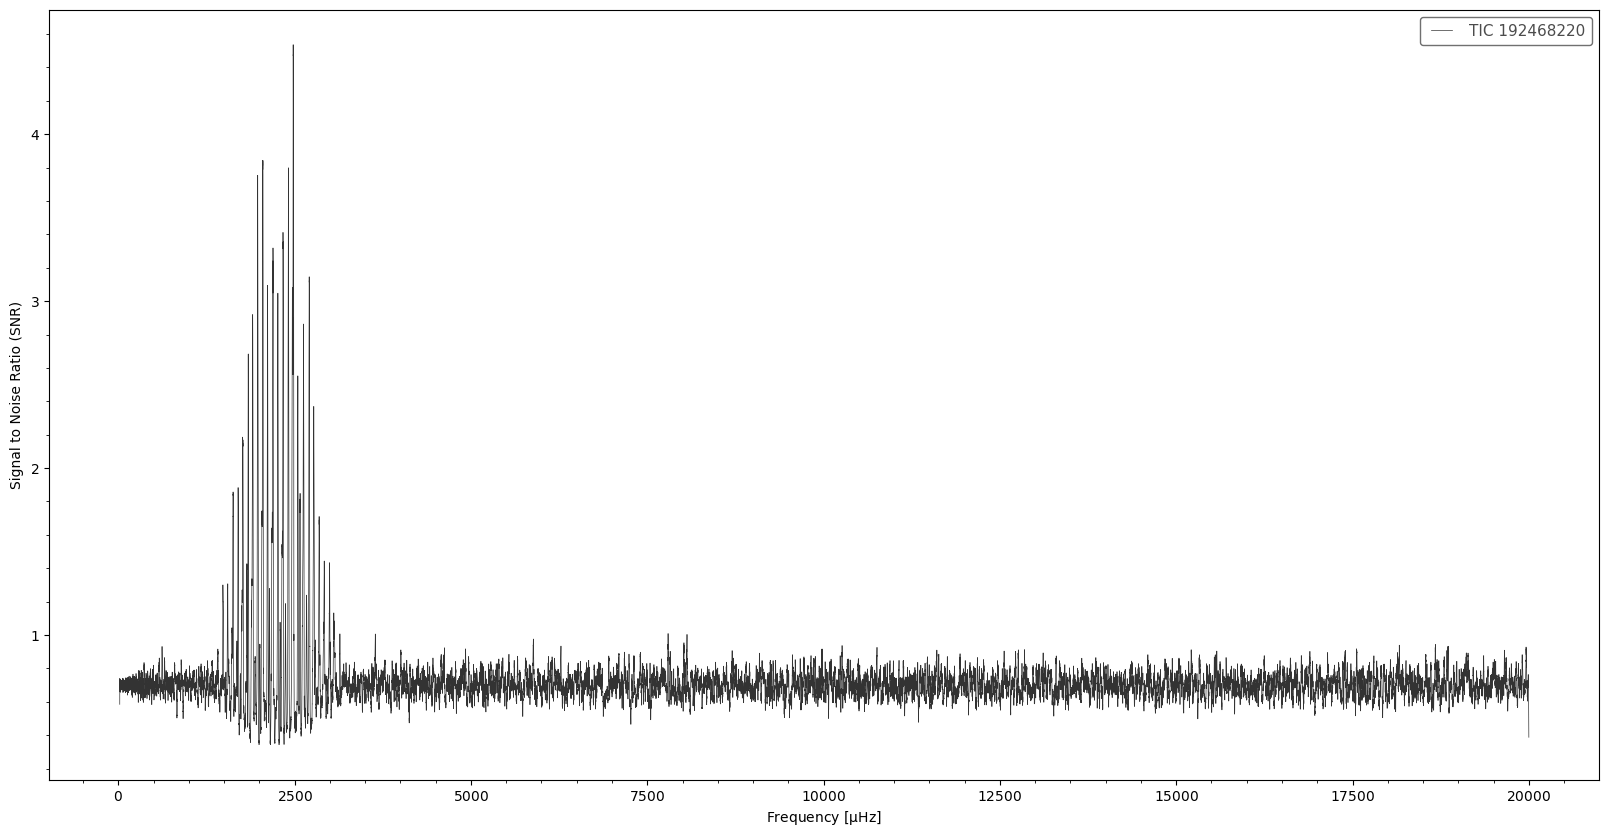

In [498]:
inject_oscillations(10,True,5,2001)

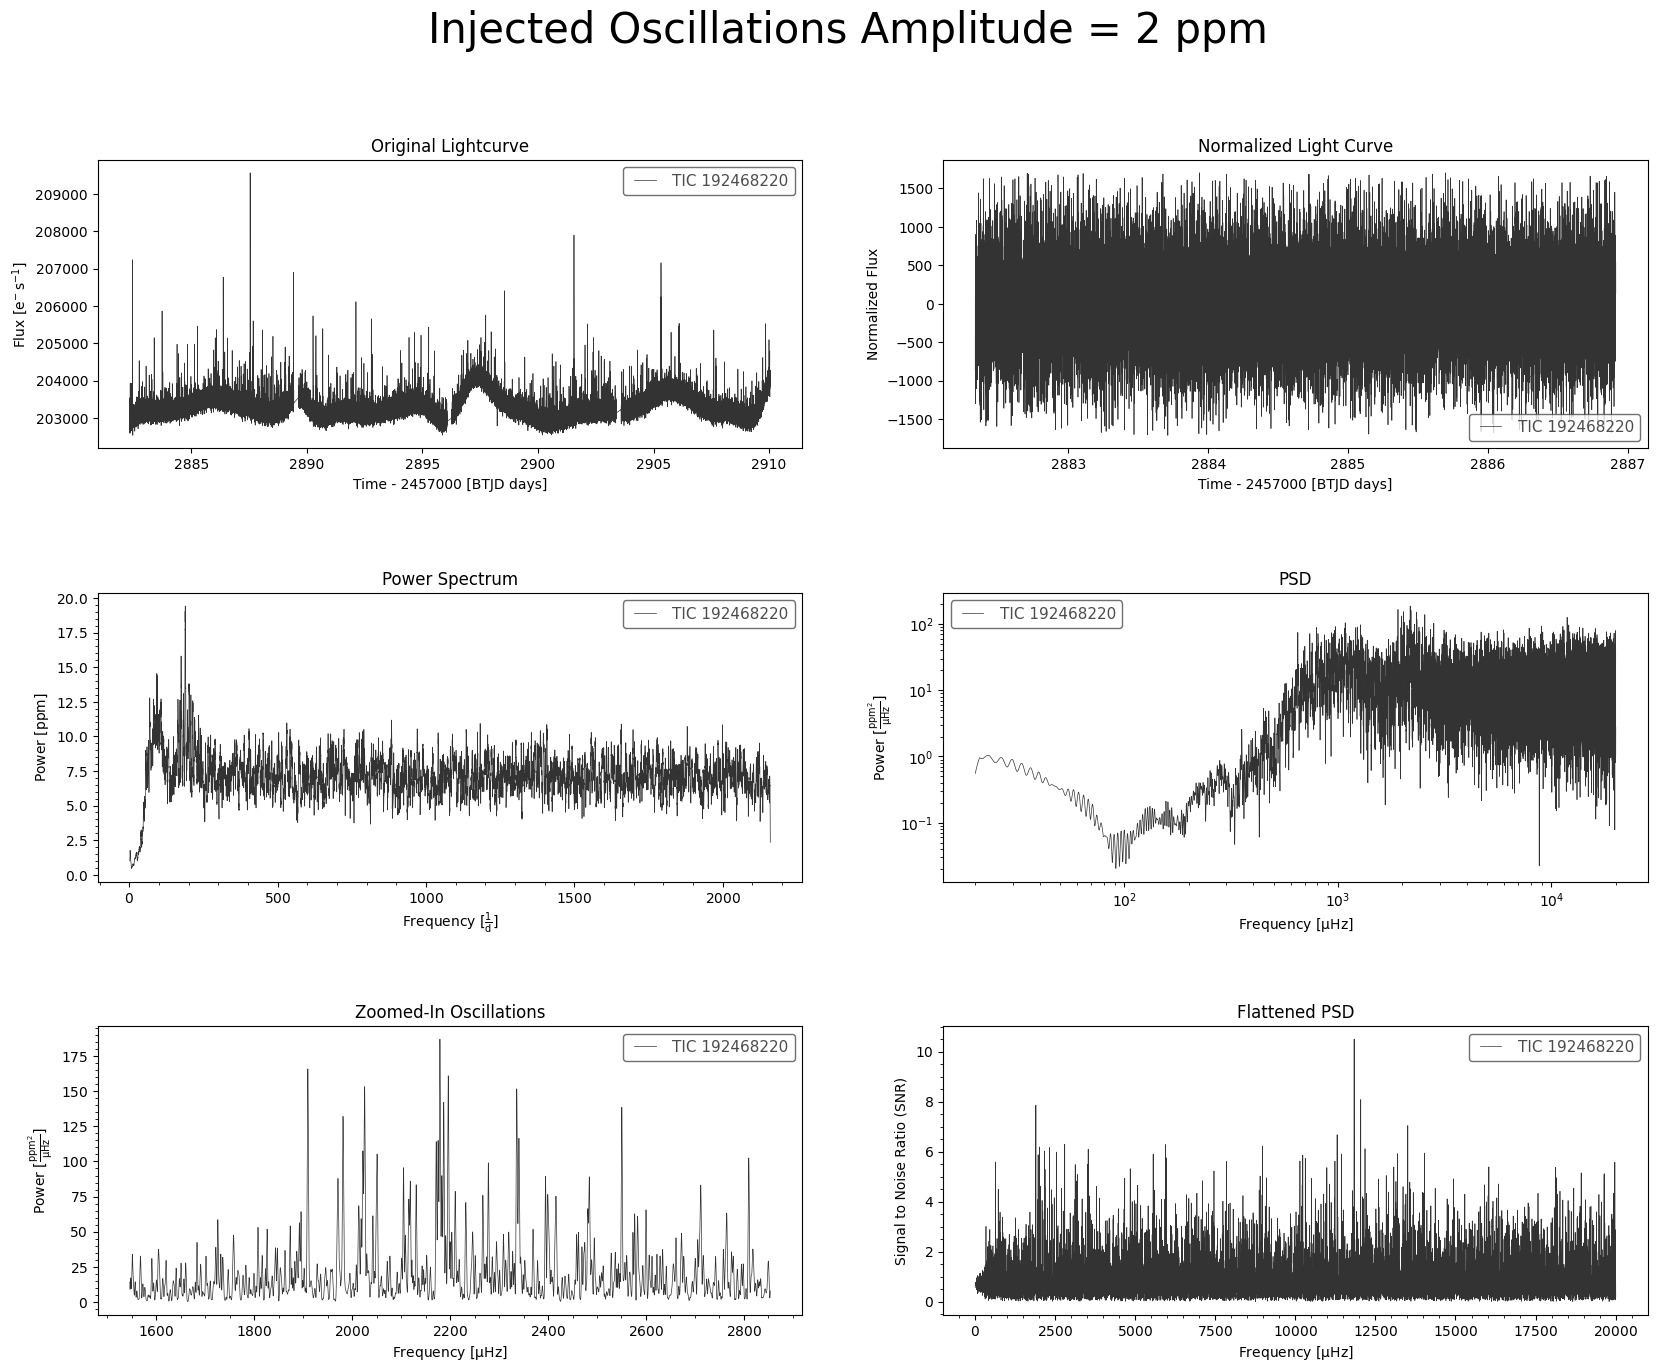

In [365]:
inject_oscillations(2)

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power [$\\mathrm{\\frac{ppm^{2}}{\\mu Hz}}$]'>

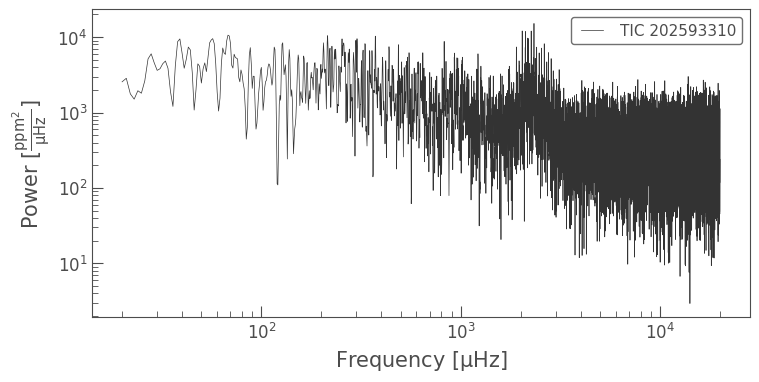

In [343]:
perio = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,1),normalization='psd').smooth(filter_width=2)
perio.plot(scale='log')
# plt.xlim(1000,3000)

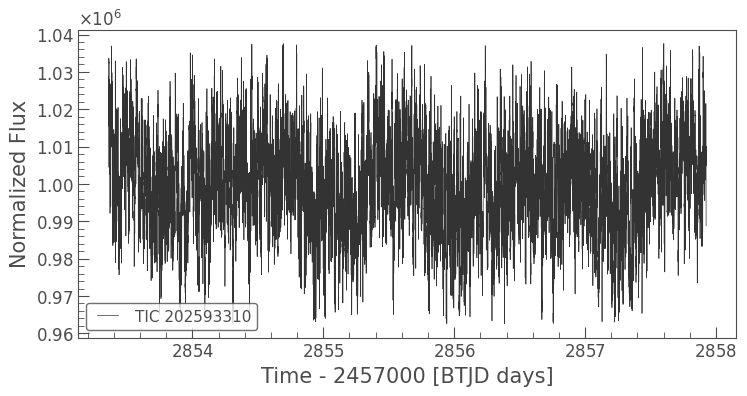

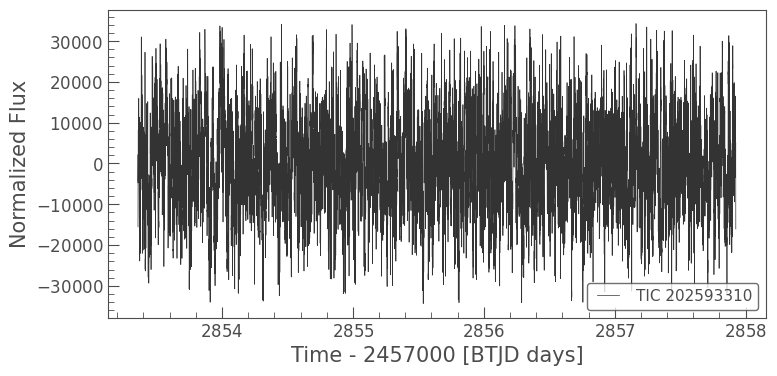

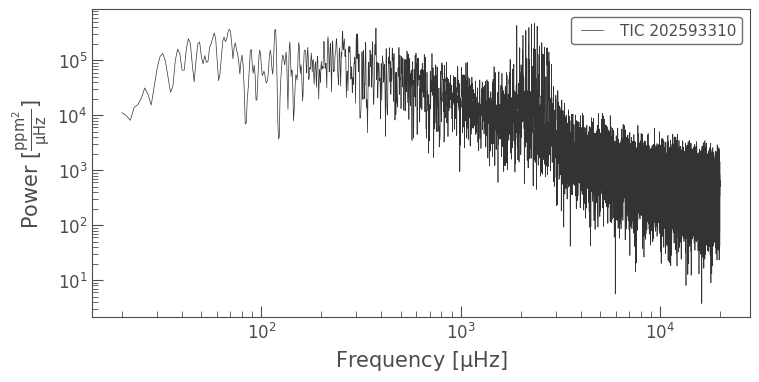

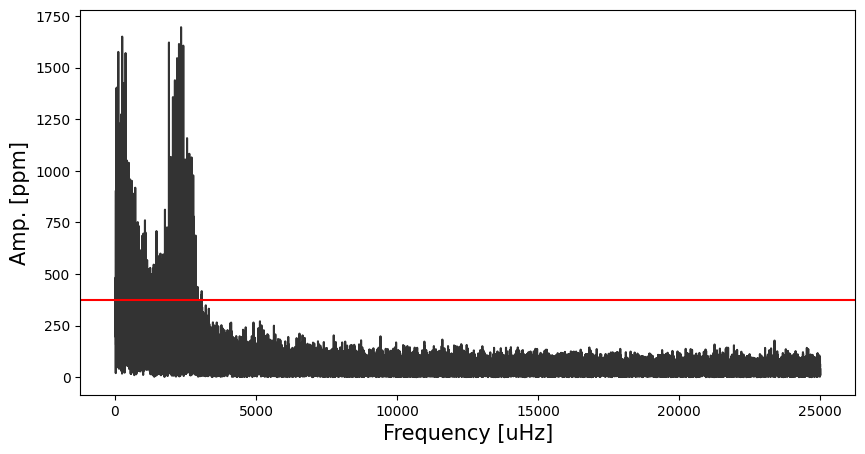

max 65.6481481481482


(LombScarglePeriodogram(ID: TIC 202593310),
 LombScarglePeriodogram(ID: TIC 202593310),
 372.71874792521123)

In [106]:
process(fake_lc.normalize(unit='ppm'),2001)

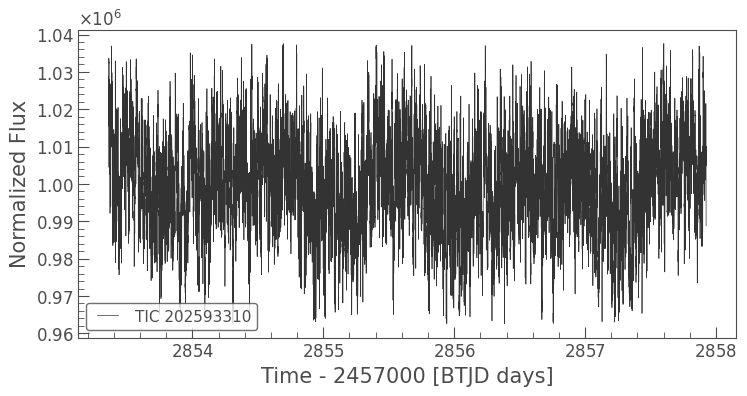

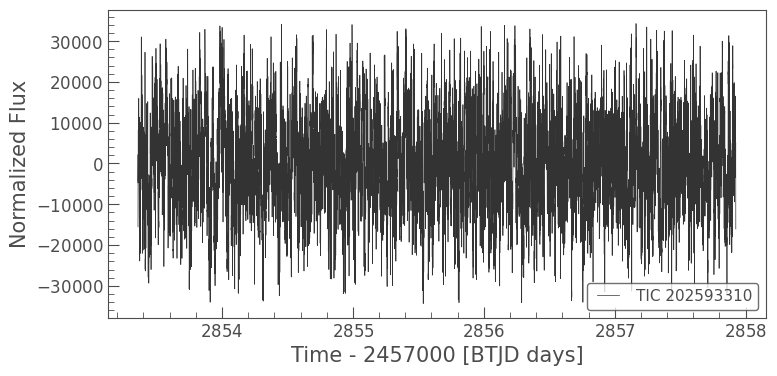

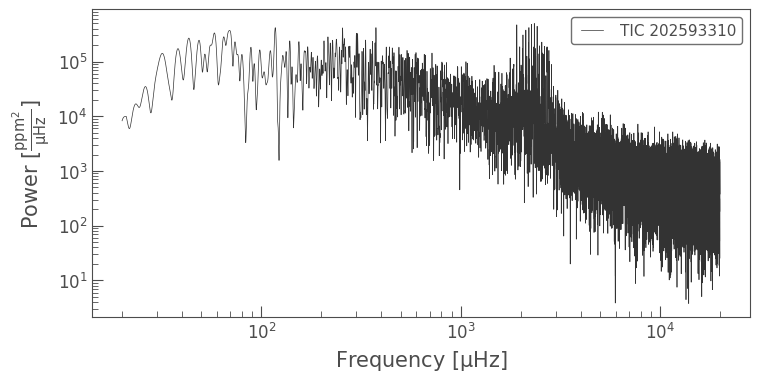

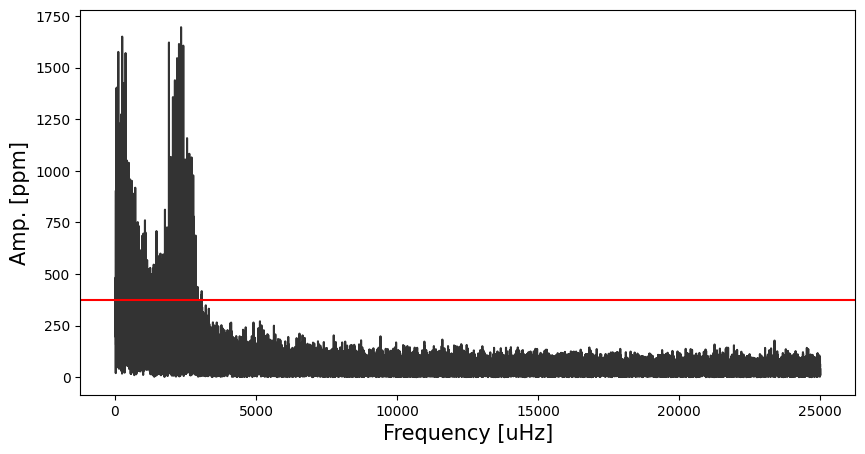

max 65.6481481481482


(LombScarglePeriodogram(ID: TIC 202593310),
 LombScarglePeriodogram(ID: TIC 202593310),
 372.71874792521123)

In [61]:
process(fake_lc.normalize(unit='ppm'),2001)

## AADG Scripts

In [68]:
def get_delta_v(M,R):
    # M and R in units of Solar mass and radius
    return (M)**.5*(R)**(-3/2)*134.9

def get_v_max(M,R,T):
    # T in Kelvin
    return 3050*(M)/((R)**(2)*(T/5777)**.5)



In [73]:
get_delta_v(.934,1.057)

119.97006850025929

In [86]:
get_v_max(.2,.4,3109)

5196.975567757227

In [ ]:
def write_namelist(cadence,n_cadences,relax_days,):
    

In [404]:
from astropy.io import fits

hdul = fits.open('/Users/caleb/Downloads/s4tess_sector_01/00014_01_0001.fits')
hdr = hdul[0].header
print(hdr['NU_MAX'])

data = hdul[2].data
print(data)

390.1667091734656
[(0,    4, 126.42366, 3.0746416e-02, 6.6738605e-04, 0.       )
 (0,    5, 153.69792, 3.2041320e-02, 7.2710519e-03, 0.       )
 (0,    6, 180.26717, 3.4578034e-02, 5.7977571e-02, 0.       )
 (0,    7, 205.35291, 3.8400987e-02, 3.2815347e-01, 0.       )
 (0,    8, 229.38037, 4.3561409e-02, 1.4042089e+00, 0.       )
 (0,    9, 253.68769, 5.0480993e-02, 4.9754311e+00, 0.       )
 (0,   10, 277.92009, 5.9313408e-02, 1.4293027e+01, 0.       )
 (0,   11, 301.62377, 7.0072731e-02, 3.2888556e+01, 0.       )
 (0,   12, 325.54116, 8.3326420e-02, 6.2466780e+01, 0.       )
 (0,   13, 349.94549, 9.9631901e-02, 9.7787542e+01, 0.       )
 (0,   14, 374.42784, 1.1913125e-01, 1.2432552e+02, 0.       )
 (0,   15, 398.91234, 1.4210535e-01, 1.2814717e+02, 0.       )
 (0,   16, 423.59139, 1.6910679e-01, 1.0683952e+02, 0.       )
 (0,   17, 448.46549, 2.0055871e-01, 7.1686063e+01, 0.       )
 (0,   18, 473.41912, 2.3671156e-01, 3.8642676e+01, 0.       )
 (0,   19, 498.42389, 2.7787620e-01, 

In [413]:
from astropy.io import fits

hdul = fits.open('/Users/caleb/Downloads/s4tess_sector_01/07055_01_0673.fits')
hdr = hdul[0].header
print(hdr['NU_MAX'])
print(hdr['A_RMSMAX'])

data = hdul[2].data
print(data)

872.712991340024
2.419686617415304
[(0,  3,  205.05273,  0.12581079, 4.1397917e-03, 0.       )
 (0,  4,  246.06535,  0.24163671, 9.8203059e-03, 0.       )
 (0,  5,  287.71985,  0.41978005, 2.2325901e-02, 0.       )
 (0,  6,  329.85215,  0.67494076, 4.8376905e-02, 0.       )
 (0,  7,  373.09138,  1.0270944 , 1.0074054e-01, 0.       )
 (0,  8,  417.52258,  1.4939037 , 2.0092108e-01, 0.       )
 (0,  9,  462.83918,  2.0854083 , 3.8026010e-01, 0.       )
 (0, 10,  508.8343 ,  2.8052106 , 6.7858609e-01, 0.       )
 (0, 11,  555.45225,  3.6509244 , 1.1376932e+00, 0.       )
 (0, 12,  602.67545,  4.6124931 , 1.7866651e+00, 0.       )
 (0, 13,  650.28441,  5.6667636 , 2.6167206e+00, 0.       )
 (0, 14,  697.92641,  6.7789289 , 3.5605596e+00, 0.       )
 (0, 15,  745.22411,  7.9084132 , 4.4934512e+00, 0.       )
 (0, 16,  791.97883,  9.0192362 , 5.2651000e+00, 0.       )
 (0, 17,  838.41393, 10.090402  , 5.7435866e+00, 0.       )
 (0, 18,  885.06797, 11.114761  , 5.8404636e+00, 0.       )
 (0, 

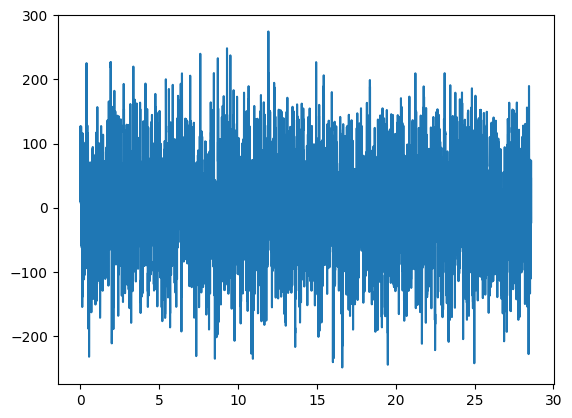

In [425]:
lc_data = hdul[1].data
plt.plot(lc_data['TIME'],lc_data['FLUX'])

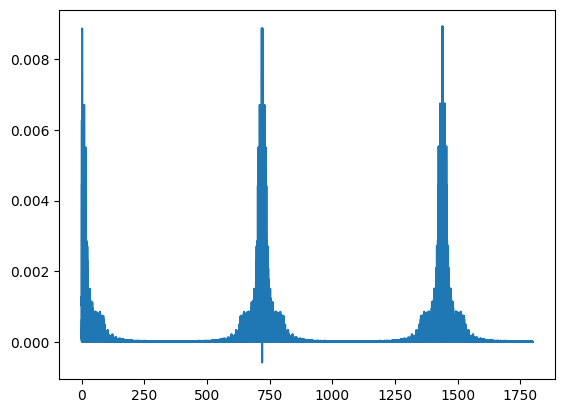

In [427]:
frequency, power = LombScargle(lc_data['TIME'],lc_data['FLUX']).autopower()
plt.plot(frequency, power)